# 300W-LP Dataset Preparation

Preprocessing this dataset is done following the instructions and script provided by: https://github.com/shamangary/FSA-Net/blob/master/README.md <br>
The resulting .npz files are extracted in this script to produce an images folder <br> with a labels.csv file.

In [1]:
import numpy as np, os, pandas as pd, shutil, scipy.io, matplotlib.pyplot as plt, PIL.Image as Image
os.chdir('..')
import cv2

In [2]:
dataset_dir = os.path.join('data', 'datasets', 'head pose estimation', '300W_LP')
os.path.exists(dataset_dir)

True

In [3]:
subdatasets = ['AFW.npz', 'AFW_Flip.npz', 'HELEN.npz', 'HELEN_Flip.npz', 'IBUG.npz', 'IBUG_Flip.npz', 'LFPW.npz', 'LFPW_Flip.npz']

In [4]:
new_images_dir = os.path.join(dataset_dir, 'Images')
os.makedirs(new_images_dir, exist_ok = True)

## extraction

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm # Optional: for a progress bar

def save_image_worker(image, save_path):
    """Helper function to write a single image."""
    cv2.imwrite(save_path, image)

# Initialize global storage
all_image_names = []
all_rolls = []
all_pitches = []
all_yaws = []

# Prepare a list of write tasks for parallel execution
write_tasks = []

global_counter = 0 # To prevent overwriting filenames

for subdataset in subdatasets:
    print(f"Loading {subdataset}...")
    data = np.load(os.path.join(dataset_dir, subdataset))
    
    # 1. Vectorized Metadata Extraction (Instant)
    poses = data['pose'] # Shape (N, 3)
    images = data['image'] # Shape (N, H, W, C)
    
    # Extract pose columns
    yaws_chunk = poses[:, 0]
    pitches_chunk = poses[:, 1]
    rolls_chunk = poses[:, 2]
    
    # Generate filenames for this chunk
    # using global_counter to ensure uniqueness: 0.jpg, 1.jpg...
    num_samples = len(images)
    indices = np.arange(global_counter, global_counter + num_samples)
    names_chunk = [f"{idx}.jpg" for idx in indices]
    
    # Store metadata in RAM (fast append)
    all_yaws.extend(yaws_chunk)
    all_pitches.extend(pitches_chunk)
    all_rolls.extend(rolls_chunk)
    all_image_names.extend(names_chunk)
    
    # 2. Prepare Image Tasks
    for img, name in zip(images, names_chunk):
        save_path = os.path.join(new_images_dir, name)
        write_tasks.append((img, save_path))
        
    global_counter += num_samples

# 3. Parallel Execution (The Speedup)
print(f"Writing {len(write_tasks)} images to disk in parallel...")

# n_jobs=-1 uses all available CPU cores
Parallel(n_jobs=-1, backend="threading")(
    delayed(save_image_worker)(img, path) for img, path in tqdm(write_tasks)
)

print("Done!")

labels_df = pd.DataFrame({
    'filename': all_image_names,
    'roll': all_rolls,
    'pitch': all_pitches,
    'yaw': all_yaws
})

Loading AFW.npz...
Loading AFW_Flip.npz...
Loading HELEN.npz...
Loading HELEN_Flip.npz...
Loading IBUG.npz...
Loading IBUG_Flip.npz...
Loading LFPW.npz...
Loading LFPW_Flip.npz...
Writing 122450 images to disk in parallel...


100%|██████████| 122450/122450 [00:11<00:00, 10708.28it/s]

Done!


In [6]:
labels_df.to_csv(
    os.path.join(dataset_dir, 'labels.csv'),
    index = False
)

# EDA

In [7]:
labels_df = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'))

In [8]:
labels_df.head()

,filename,roll,pitch,yaw
0,0.jpg,1.523025,-5.037351,0.239520
1,1.jpg,2.212797,-7.089375,5.239520
2,2.jpg,2.253691,-7.032664,50.239521
3,3.jpg,1.550220,-6.688949,55.239520
4,4.jpg,2.234273,-7.176032,60.239523


In [9]:
from utility_scripts.pose_estimation_utilities import draw_axis
import cv2

In [10]:
figures_dir = os.path.join('data', 'figures', 'Pose estimation', '300W-LP')
os.makedirs(figures_dir, exist_ok = True)

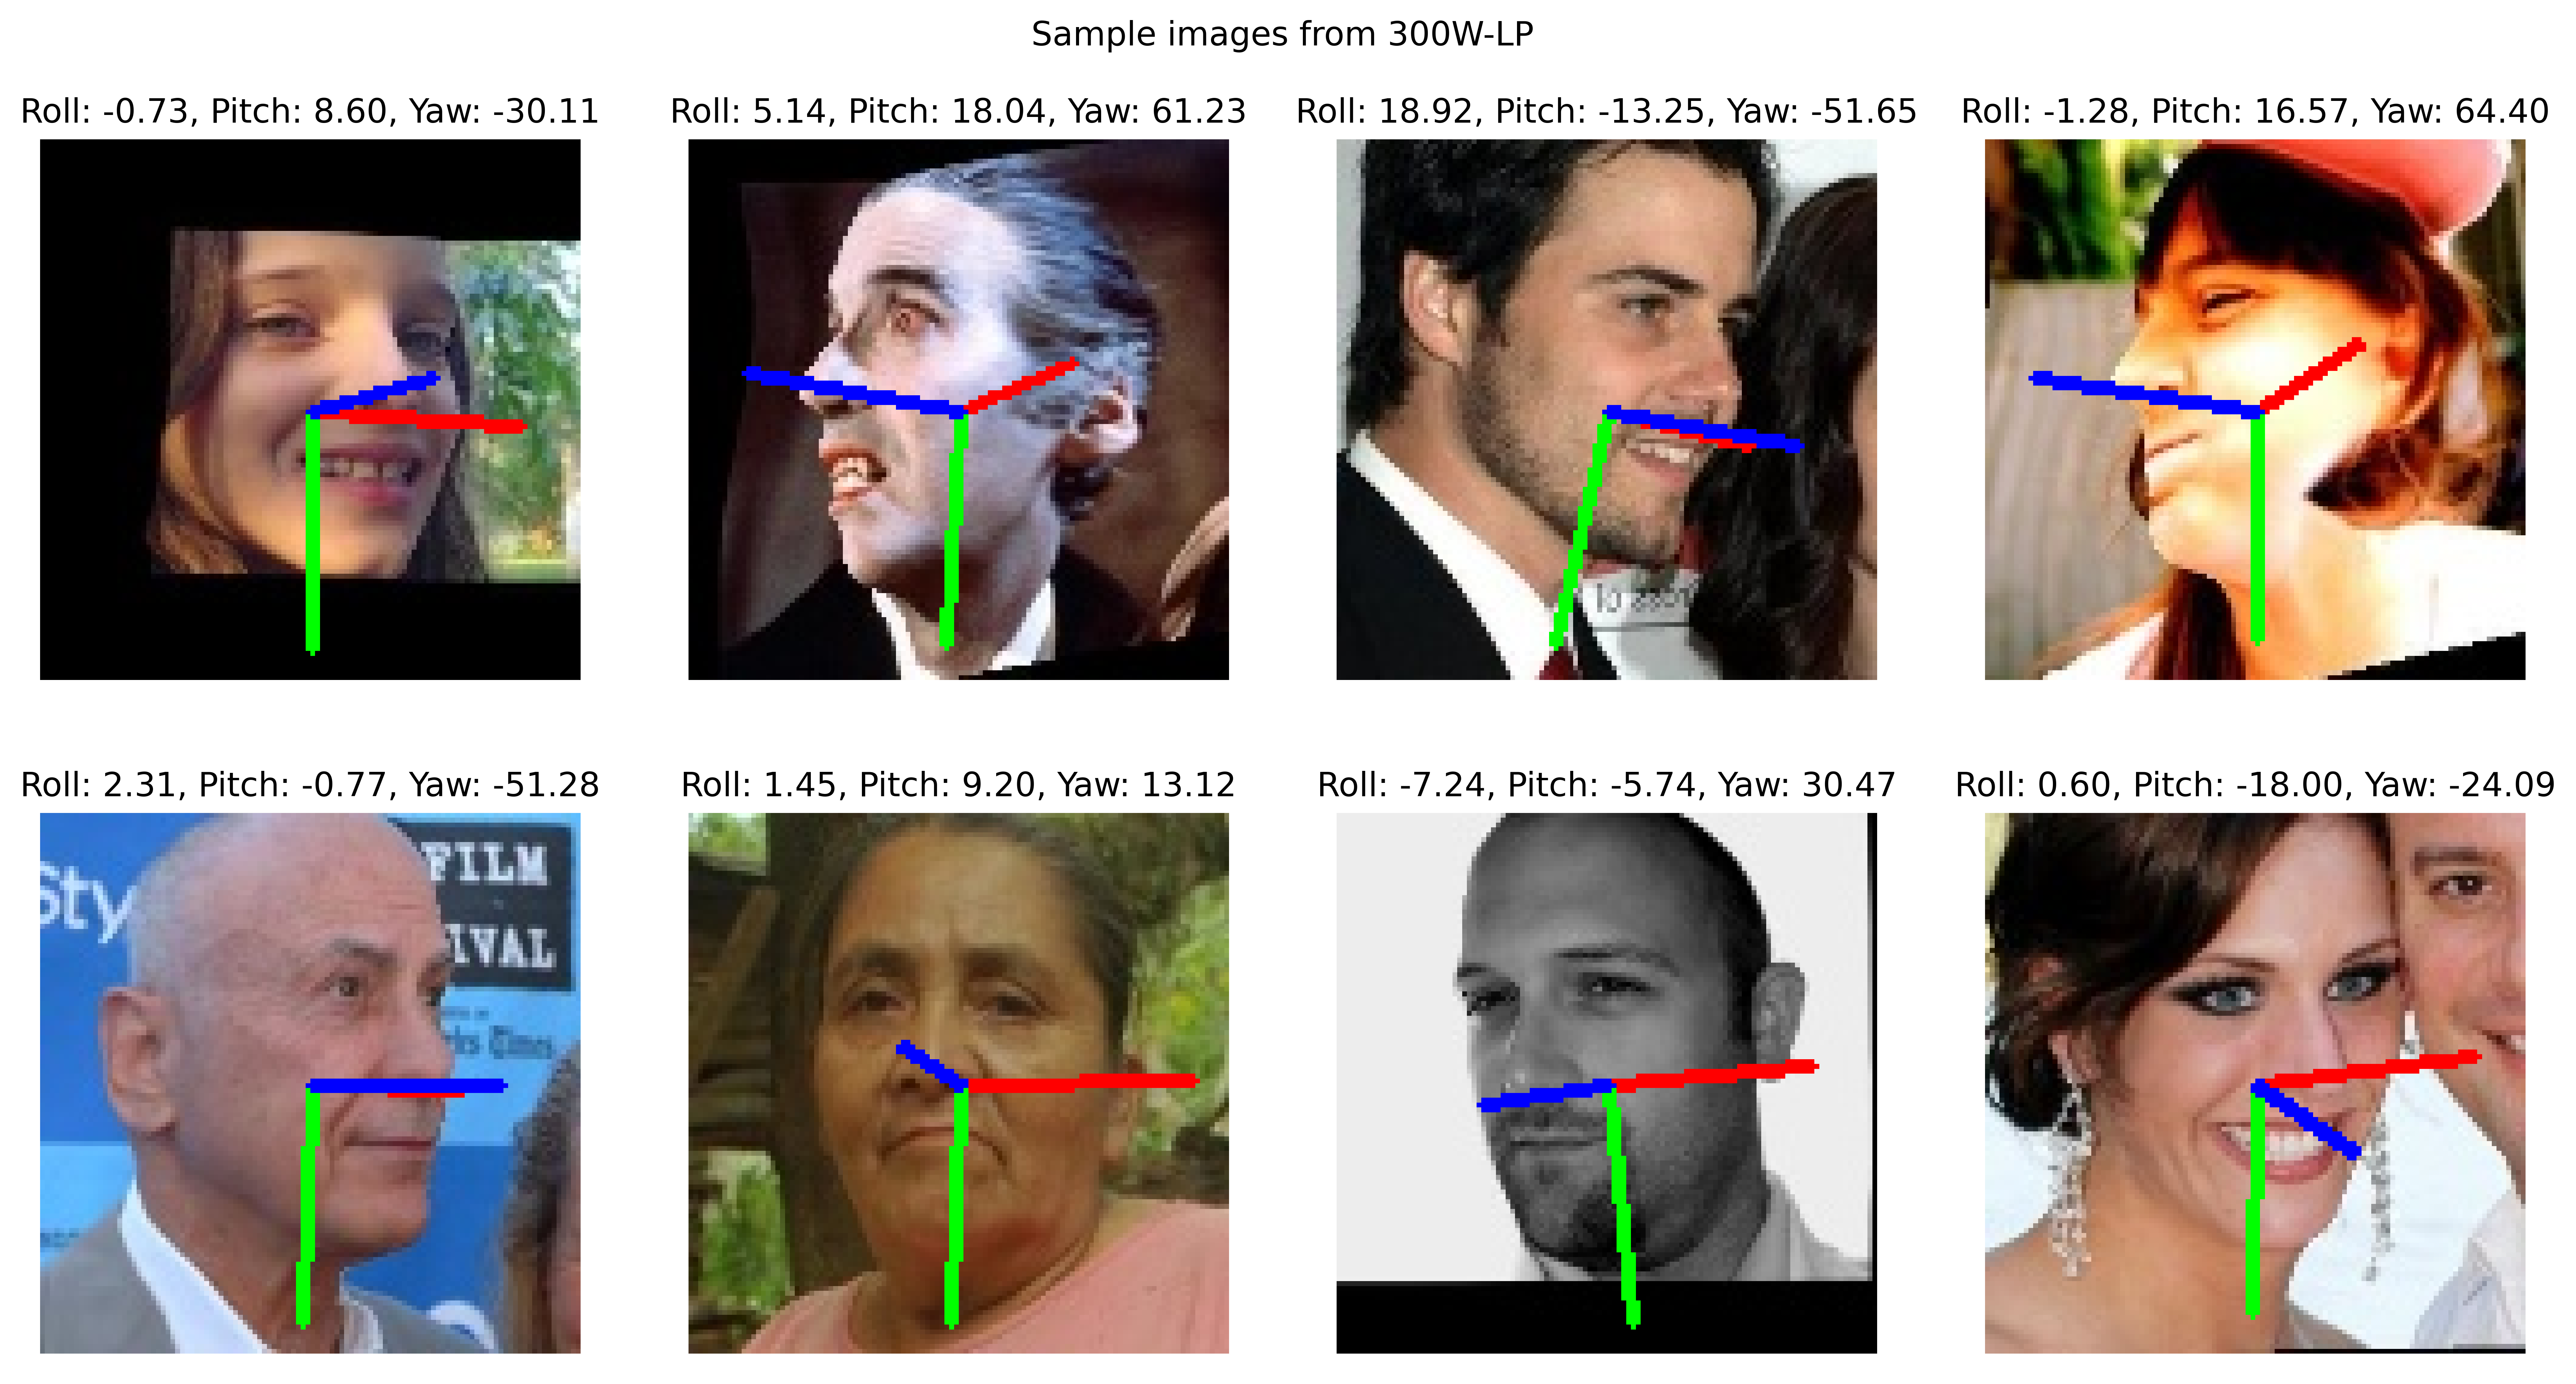

In [11]:
plt.figure(figsize = (16, 8), dpi = 600)
plt.axis('off')
plt.title('Sample images from 300W-LP', pad = 30)
for i in range(8):
    index = np.random.randint(low = 0, high = len(labels_df))
    image = cv2.imread(
        os.path.join(new_images_dir, labels_df.filename[index]),
        cv2.IMREAD_COLOR_RGB
    )
    roll = labels_df.roll[index]
    pitch = labels_df.pitch[index]
    yaw = labels_df.yaw[index]
    image = draw_axis(image, yaw = yaw, pitch = pitch, roll = roll)

    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f'Roll: {roll:.2f}, Pitch: {pitch:.2f}, Yaw: {yaw:.2f}')
    plt.axis('off')
plt.savefig(
    os.path.join(figures_dir, 'sample images')
)
plt.show()